In [1]:
import click
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import MNIST
from tensorboardX import SummaryWriter
import uuid

from ptdec.dec import DEC
from ptdec.model import train, predict
from ptsdae.sdae import StackedDenoisingAutoEncoder
import ptsdae.model as ae
from ptdec.utils import cluster_accuracy

In [2]:
class CachedMNIST(Dataset):
    def __init__(self, train, cuda, testing_mode=False):
        img_transform = transforms.Compose([transforms.Lambda(self._transformation)])
        self.ds = MNIST("./DEC-data", download=True, train=train, transform=img_transform)
        self.cuda = cuda
        self.testing_mode = testing_mode
        self._cache = dict()

    @staticmethod
    def _transformation(img):
        return (
            torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).float()
            * 0.02
        )

    def __getitem__(self, index: int) -> torch.Tensor:
        if index not in self._cache:
            self._cache[index] = list(self.ds[index])
            if self.cuda:
                self._cache[index][0] = self._cache[index][0].cuda(non_blocking=True)
                self._cache[index][1] = torch.tensor(
                    self._cache[index][1], dtype=torch.long
                ).cuda(non_blocking=True)
        return self._cache[index]

    def __len__(self) -> int:
        return 128 if self.testing_mode else len(self.ds)

In [4]:
cuda=False
batch_size=256
pretrain_epochs=10
finetune_epochs=10
testing_mode=False # whether to run in testing mode (default False).

In [5]:
def main(cuda, batch_size, pretrain_epochs, finetune_epochs, testing_mode):
    writer = SummaryWriter()  # create the TensorBoard object
    # callback function to call during training, uses writer from the scope

    def training_callback(epoch, lr, loss, validation_loss):
        writer.add_scalars(
            "data/autoencoder",
            {"lr": lr, "loss": loss, "validation_loss": validation_loss,},
            epoch,
        )

    ds_train = CachedMNIST(
        train=True, cuda=cuda, testing_mode=testing_mode
    )  # training dataset
    ds_val = CachedMNIST(
        train=False, cuda=cuda, testing_mode=testing_mode
    )  # evaluation dataset
    autoencoder = StackedDenoisingAutoEncoder(
        [28 * 28, 500, 500, 2000, 10], final_activation=None
    )
    if cuda:
        autoencoder.cuda()
    print("Pretraining stage.")
    
    ## Wenqi: weird that pretrain and fine-tune with the same dataset...
    # The only difference seems to be the scheduler they used. (even the scheduler and optimizer are the same)
    # So I guess the author's purpose here is to make pretraining easier for other tasks, 
    # e.g., pretrain with MNIST, then fine-tune on other datasets...
    # No! I read their code: https://github.com/vlukiyanov/pt-sdae/blob/master/ptsdae/model.py
    # pretrain: train each single encoder and decoders (layer by layer)
    # train: train the entire stacked AE
    ae.pretrain(
        ds_train,
        autoencoder,
        cuda=cuda,
        validation=ds_val,
        epochs=pretrain_epochs,
        batch_size=batch_size,
        optimizer=lambda model: SGD(model.parameters(), lr=0.1, momentum=0.9),
        scheduler=lambda x: StepLR(x, 100, gamma=0.1),
        corruption=0.2,
    )
    print("Training stage.")
    ae_optimizer = SGD(params=autoencoder.parameters(), lr=0.1, momentum=0.9)
    ae.train(
        ds_train,
        autoencoder,
        cuda=cuda,
        validation=ds_val,
        epochs=finetune_epochs,
        batch_size=batch_size,
        optimizer=ae_optimizer,
        scheduler=StepLR(ae_optimizer, 100, gamma=0.1),
        corruption=0.2,
        update_callback=training_callback,
    )
    print("DEC stage.")
    model = DEC(cluster_number=10, hidden_dimension=10, encoder=autoencoder.encoder)
    if cuda:
        model.cuda()
    dec_optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    train(
        dataset=ds_train,
        model=model,
        epochs=100,
        batch_size=256,
        optimizer=dec_optimizer,
        stopping_delta=0.000001,
        cuda=cuda,
    )
    predicted, actual = predict(
        ds_train, model, 1024, silent=True, return_actual=True, cuda=cuda
    )
    actual = actual.cpu().numpy()
    predicted = predicted.cpu().numpy()
    reassignment, accuracy = cluster_accuracy(actual, predicted)
    print("Final DEC accuracy: %s" % accuracy)
    if not testing_mode:
        predicted_reassigned = [
            reassignment[item] for item in predicted
        ]  # TODO numpify
        confusion = confusion_matrix(actual, predicted_reassigned)
        normalised_confusion = (
            confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]
        )
        confusion_id = uuid.uuid4().hex
        sns.heatmap(normalised_confusion).get_figure().savefig(
            "confusion_%s.png" % confusion_id
        )
        print("Writing out confusion diagram with UUID: %s" % confusion_id)
        writer.close()

0it [00:00, ?it/s]

Extracting ./DEC-data/MNIST/raw/train-images-idx3-ubyte.gz to ./DEC-data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./DEC-data/MNIST/raw/train-labels-idx1-ubyte.gz to ./DEC-data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./DEC-data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./DEC-data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./DEC-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./DEC-data/MNIST/raw
Processing...


/home/wejiang/anaconda3/envs/hnswlib/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:117: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Done!
Pretraining stage.



 25%|██████████████████████████▎                                                                              | 59/235 [00:03<00:09, 18.96batch/s, epo=0, lss=1.436387, vls=-1.000000]


 53%|███████████████████████████████████████████████████████▎                                                | 125/235 [00:06<00:05, 20.93batch/s, epo=0, lss=1.166953, vls=-1.000000]


 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 188/235 [00:10<00:03, 13.87batch/s, epo=0, lss=1.040088, vls=-1.000000]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:05<00:00, 42.04batch/s, epo=9, lss=0.063934, vls=0.018822]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:01<00:00, 163.20batch/s, epo=9, lss=0.004832, vls=0.005057]


Training stage.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:16<00:00, 13.94batch/s, epo=9, lss=0.504649, vls=0.515266]


DEC stage.


100%|███████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:02<00:00, 84.25batch/s, acc=0.0000, dlb=-1.0000, epo=-1, lss=0.00000000]
/home/wejiang/anaconda3/envs/hnswlib/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:11<00:00, 20.89batch/s, acc=0.6238, dlb=0.0159, epo=85, lss=0.05364330]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:11<00:00, 20.72batch/s, acc=0.6130, dlb=0.0362, epo=99, lss=0.05436240]


Final DEC accuracy: 0.5824166666666667
Writing out confusion diagram with UUID: 983f11f70e9048c797bb08d01c88722b


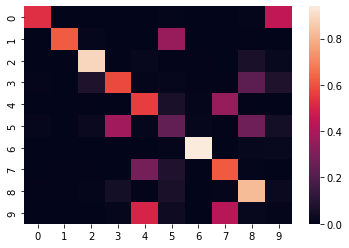

In [7]:
main(cuda, batch_size, pretrain_epochs, finetune_epochs, testing_mode)

In [8]:
ds_train = CachedMNIST(
    train=True, cuda=cuda, testing_mode=testing_mode
)

In [11]:
type(ds_train)

__main__.CachedMNIST

In [12]:
ds_train.ds

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./DEC-data
    Split: Train
    StandardTransform
Transform: Compose(
               Lambda()
           )

In [14]:
dir(ds_train.ds)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 '_format_transform_repr',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'data',
 'download',
 'extra_repr',
 'processed_folder',
 'raw_folder',
 'resources',
 'root',
 'target_transform',
 'targets',
 'test_data',
 'test_file',
 'test_labels',
 'train',
 'train_data',
 'train_labels',
 'training_file',
 'transform',
 'transforms']

In [15]:
ds_train.ds.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [20]:
ds_train.ds.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [19]:
ds_train.ds.train_labels

/home/wejiang/anaconda3/envs/hnswlib/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5, 0, 4,  ..., 5, 6, 8])

In [24]:
ds_train.ds.__getitem__(1)

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0